# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score # Usar isso?
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.svm import SVC

import pickle as pkl # to save the model

# Leitura dos dados

In [2]:
# Reading Tokenized Data

data = pd.read_csv('news_tokens.csv')

data.head()

,headline,short_description,mix,category
0,golden globe return nbc januari year,past month hollywood effect boycot globe repor...,past month hollywood effect boycot globe repor...,ENTERTAINMENT
1,biden say forc would defend taiwan china invad,presid issu vow tension china rise,presid issu vow tension china rise biden say f...,POLITICS
2,beauti sad time ukrainian cultur festiv take d...,annual celebr took differ feel russia invas dr...,annual celebr took differ feel russia invas dr...,POLITICS
3,jame cameron say studio releas,avatar director said aspect movi still competi...,avatar director said aspect movi still competi...,ENTERTAINMENT
4,biden say queen death left hole royal famili,presid joe biden london funer queen elizabeth ...,presid joe biden london funer queen elizabeth ...,POLITICS


In [3]:
# Iremos usar apenas o MIX e sua respectiva categoria

# Dropando as colunas que não serão usadas
data = data.drop(columns = ['headline', 'short_description'])
data.tail()

,mix,category
84214,step seren plantat follow narrow damp twisti t...,TRAVEL
84215,ida love say gear birthday may ida thrive dail...,WELLNESS
84216,look back daili column highlight moment fashio...,STYLE & BEAUTY
84217,represent collect diaspora alway thwart need c...,ENTERTAINMENT
84218,soni pictur releas girl dragon tattoo censor b...,ENTERTAINMENT


In [4]:
# Convertendo a coluna de categoria para valores numéricos usando LabelEncoder
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])

data.tail()

,mix,category
84214,step seren plantat follow narrow damp twisti t...,3
84215,ida love say gear birthday may ida thrive dail...,4
84216,look back daili column highlight moment fashio...,2
84217,represent collect diaspora alway thwart need c...,0
84218,soni pictur releas girl dragon tattoo censor b...,0


# Vetorização de texto

## Por frequência inversa

In [5]:
# Cortando a vetorização para as 10000 palavras mais frequentes ou com min_df = 0.001, ou seja, palavras que aparecem em pelo menos 0.1% dos documentos
inverse_frequency_vectorizer = TfidfVectorizer(max_features=10000, min_df = 0.001)

# Fit the vectorizer to the data

inverse_frequency_vectorizer.fit(data['mix'])

# Transform the data

inverse_frequency_matrix = inverse_frequency_vectorizer.transform(data['mix'])

print(inverse_frequency_matrix.shape)

(84219, 2625)


# Separação dos dados em treino e teste

In [6]:
# 80% dos dados para treino e validacao com kfold = 5 e 20% para teste de forma estratificada (mesma proporção de classes)

X_train_val, X_test, y_train_val, y_test = train_test_split(inverse_frequency_matrix, data['category'], test_size=0.2, random_state=42, stratify=data['category'])

print(X_train_val.shape, X_test.shape)

(67375, 2625) (16844, 2625)


# Regressão Logística

In [7]:
# Regressão Logística

log = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)

# Grid Search

param_grid = {'C': [0.1, 0.5, 1, 1.5, 2],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']} #  Unicos que podem ser usados com multiclass

grid_search = GridSearchCV(estimator=log, param_grid=param_grid, cv=5)

grid_search.fit(X_train_val, y_train_val)


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial',
                                          n_jobs=-1),
             param_grid={'C': [0.1, 0.5, 1, 1.5, 2],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']})

In [11]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

{'C': 2, 'solver': 'saga'}


0.8813358070500927


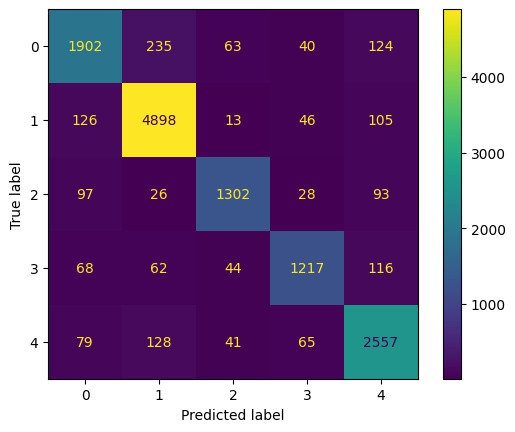

0.8845269016697588


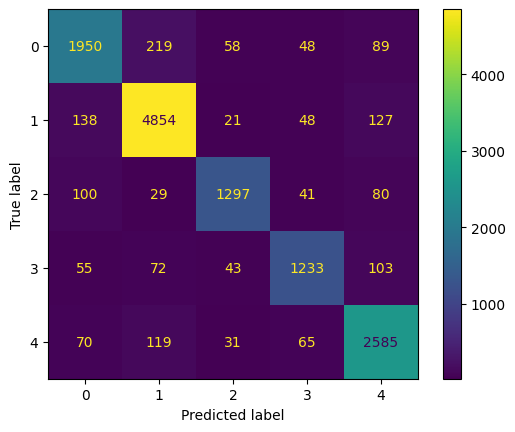

0.8807421150278293


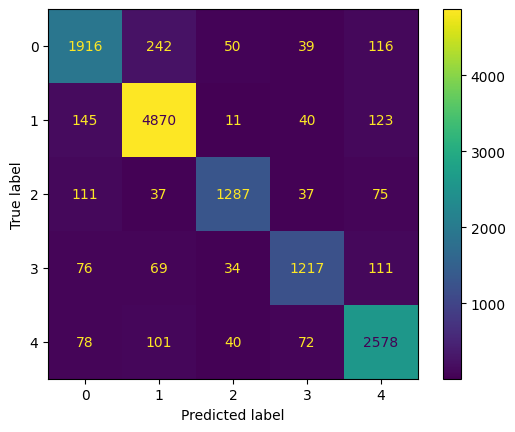

0.8819294990723562


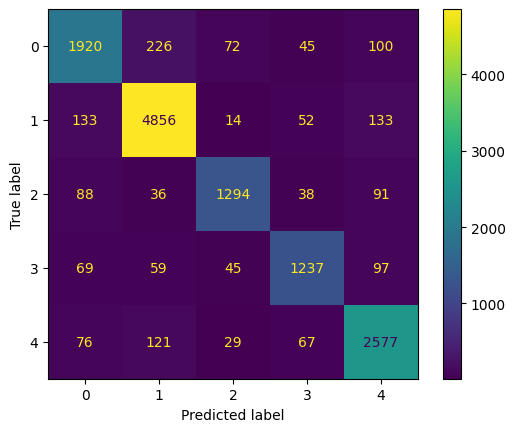

0.8833395176252319


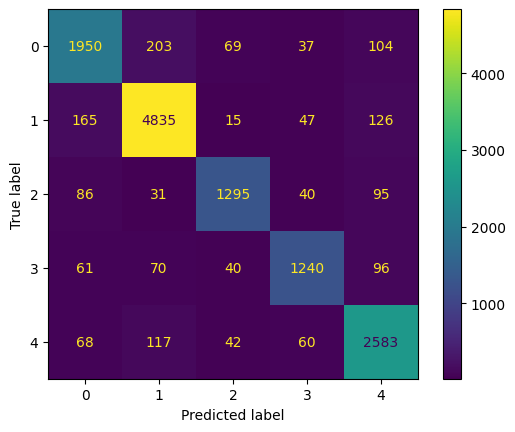

In [12]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation

solver = grid_search.best_params_['solver']
C = grid_search.best_params_['C']

log = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1, solver=solver, C=C)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    log.fit(X_train, y_train)
    y_pred = log.predict(X_val)
    print(accuracy_score(y_val, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


0.8849441937782


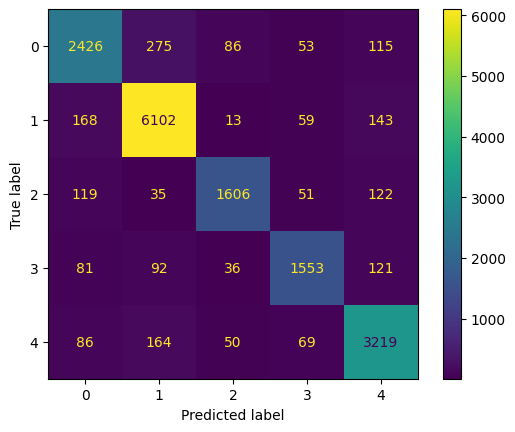

In [13]:
# Testando no conjunto de teste

log.fit(X_train_val, y_train_val)
y_pred = log.predict(X_test)

print(accuracy_score(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [14]:
# F1 Score

f1_score(y_test, y_pred, average='weighted')

0.8844022965860785

In [15]:
# Classification Report
classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

{'ENTERTAINMENT': {'precision': 0.8423611111111111,
  'recall': 0.8209813874788494,
  'f1-score': 0.8315338474721509,
  'support': 2955.0},
 'POLITICS': {'precision': 0.915116976604679,
  'recall': 0.940940632228219,
  'f1-score': 0.9278491598874781,
  'support': 6485.0},
 'STYLE & BEAUTY': {'precision': 0.8967057509771078,
  'recall': 0.8308329022245214,
  'f1-score': 0.8625134264232008,
  'support': 1933.0},
 'TRAVEL': {'precision': 0.8700280112044818,
  'recall': 0.8247477429633564,
  'f1-score': 0.846782988004362,
  'support': 1883.0},
 'WELLNESS': {'precision': 0.8653225806451613,
  'recall': 0.8971571906354515,
  'f1-score': 0.880952380952381,
  'support': 3588.0},
 'accuracy': 0.8849441937782,
 'macro avg': {'precision': 0.8779068861085083,
  'recall': 0.8629319711060797,
  'f1-score': 0.8699263605479146,
  'support': 16844.0},
 'weighted avg': {'precision': 0.8845929148483915,
  'recall': 0.8849441937782,
  'f1-score': 0.8844022965860785,
  'support': 16844.0}}

In [16]:
# Salvando o modelo

pkl.dump(log, open('logistic_regression_model.pkl', 'wb'))

# Floresta Aleatória

In [27]:
# Random Forest

rf = RandomForestClassifier(n_jobs=-1) # n_jobs=-1 para usar todos os cores do processador!

# Grid Search

param_grid = {'n_estimators': [100, 300],
                'max_depth': [25, 50 ,100], # Talvez aumentar o max_depth?
                'max_features': ['sqrt', 'log2'], 
                'criterion': ['gini', 'entropy']} 

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(X_train_val, y_train_val)

KeyboardInterrupt: 

In [26]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

0.8274582560296846


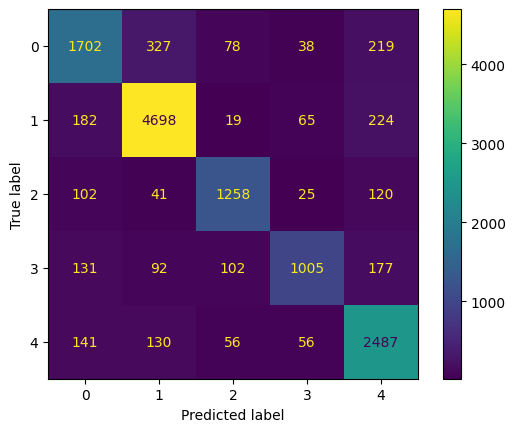

KeyboardInterrupt: 

In [32]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation

# n_estimators = grid_search.best_params_['n_estimators']
# max_depth = grid_search.best_params_['max_depth']
# max_features = grid_search.best_params_['max_features']
# criterion = grid_search.best_params_['criterion']

n_estimators = 400 # Nao influencia muito
max_depth = 200 # Importante, quanto maior melhor
max_features = 'sqrt'
criterion = 'entropy'

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, criterion=criterion, n_jobs=-1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print(accuracy_score(y_val, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

0.8328781762051769


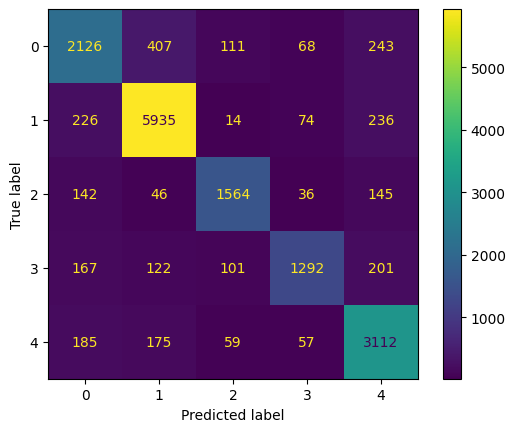

In [33]:
# Testando no conjunto de teste

rf.fit(X_train_val, y_train_val)
y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [34]:
# Classification Report
classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

{'ENTERTAINMENT': {'precision': 0.7470133520730851,
  'recall': 0.7194585448392555,
  'f1-score': 0.7329770729184623,
  'support': 2955.0},
 'POLITICS': {'precision': 0.8878085265519821,
  'recall': 0.9151888974556669,
  'f1-score': 0.9012908124525436,
  'support': 6485.0},
 'STYLE & BEAUTY': {'precision': 0.8458626284478096,
  'recall': 0.8091050181065701,
  'f1-score': 0.8270756213643575,
  'support': 1933.0},
 'TRAVEL': {'precision': 0.8461034708578913,
  'recall': 0.6861391396707381,
  'f1-score': 0.7577712609970673,
  'support': 1883.0},
 'WELLNESS': {'precision': 0.7904495808991618,
  'recall': 0.867335562987737,
  'f1-score': 0.827109634551495,
  'support': 3588.0},
 'accuracy': 0.8328781762051769,
 'macro avg': {'precision': 0.8234475117659859,
  'recall': 0.7994454326119935,
  'f1-score': 0.8092448804567851,
  'support': 16844.0},
 'weighted avg': {'precision': 0.8328936798116117,
  'recall': 0.8328781762051769,
  'f1-score': 0.8314003798714289,
  'support': 16844.0}}

['gop', 'republican', 'democrat', 'presid', 'donald', 'style', 'fashion', 'travel', 'photo', 'trump']


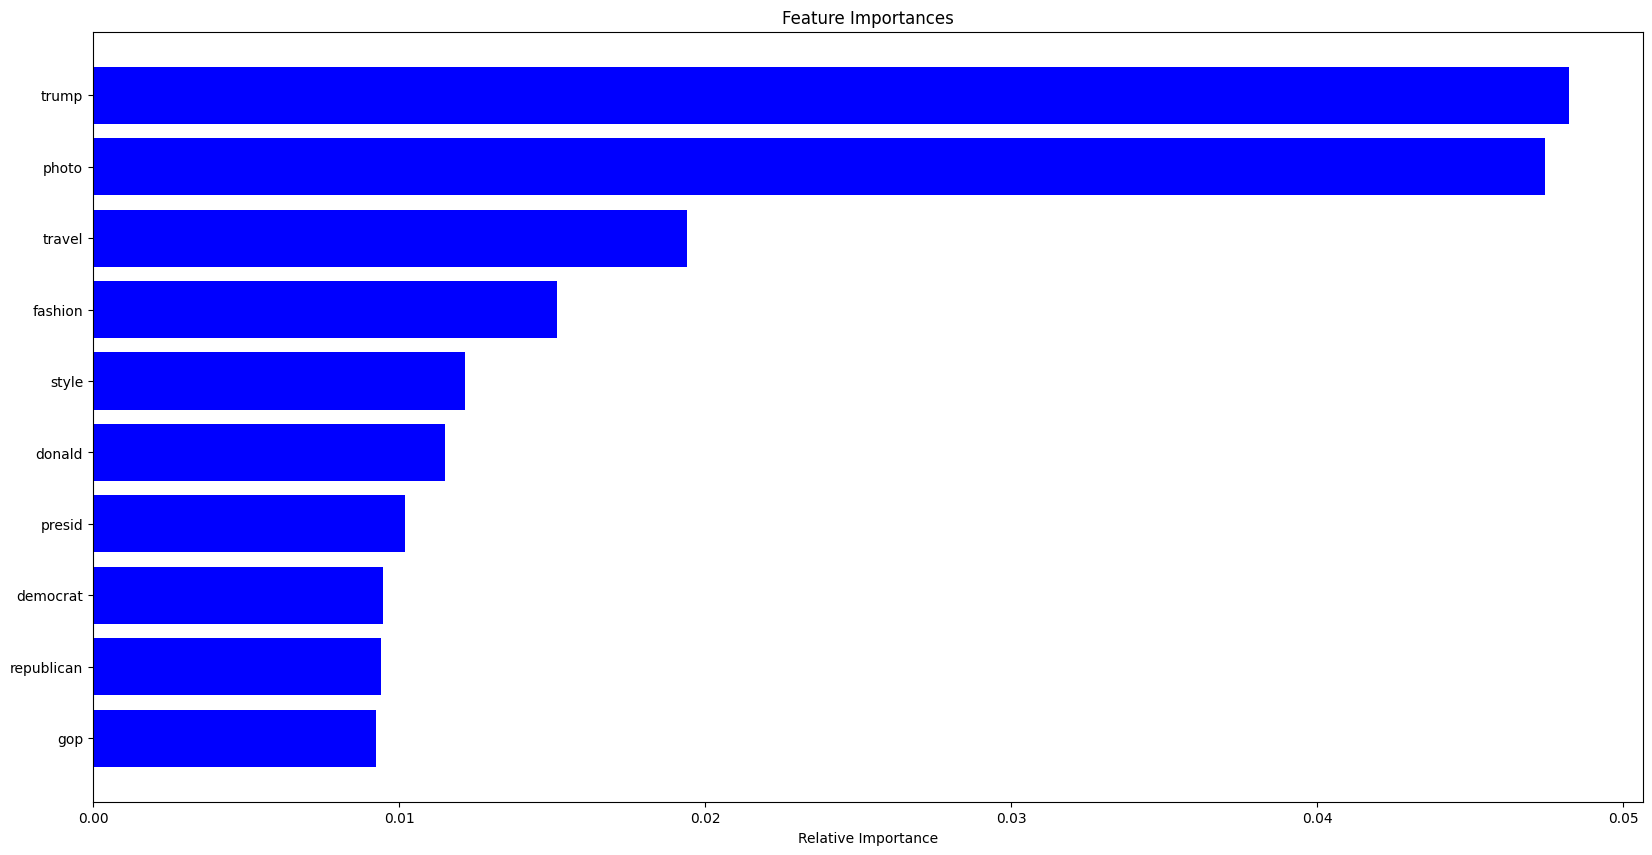

In [35]:
# Plotando a importância das features no modelo (10 mais importantes) 
# (https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

features = inverse_frequency_vectorizer.get_feature_names_out()
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

top_features = [features[i] for i in indices]

print(top_features)

plt.figure(figsize=(20, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), top_features)
plt.xlabel('Relative Importance')
plt.show()

# sns.barplot(x=rf.feature_importances_, y=inverse_frequency_vectorizer.get_feature_names_out())


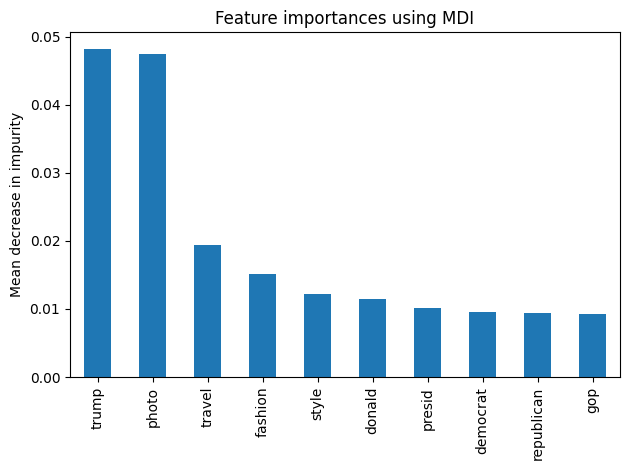

In [36]:
# Plotando a importância das features no modelo (10 mais importantes) usando outra abordagem

forest_importances = pd.Series(rf.feature_importances_, index=inverse_frequency_vectorizer.get_feature_names_out())
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.nlargest(10).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

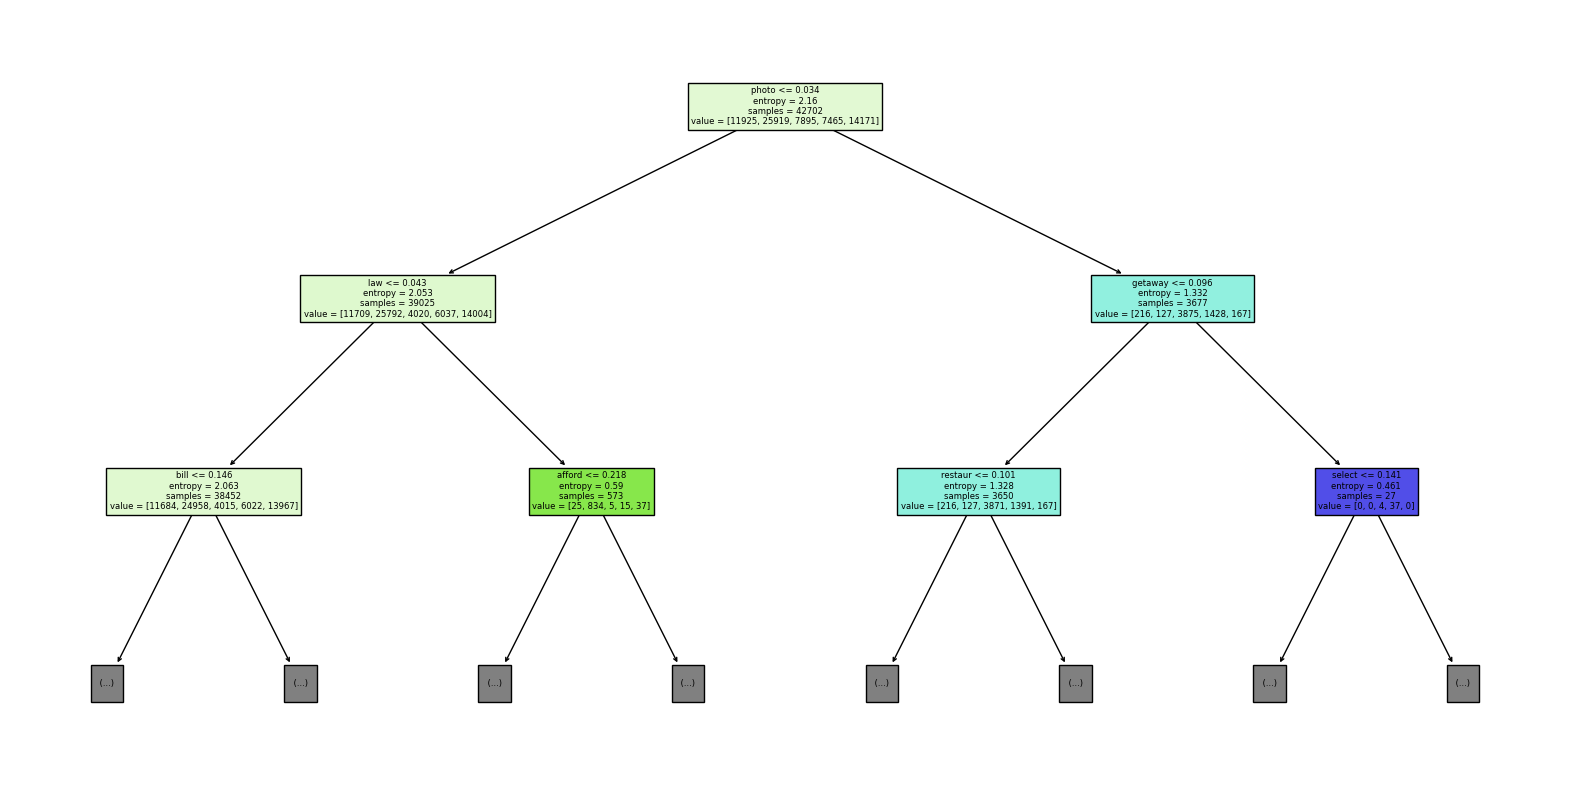

In [38]:
# Mostrando a arvore de decisão

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], max_depth=2, feature_names=inverse_frequency_vectorizer.get_feature_names_out(), filled=True)
plt.show()

In [39]:
# Salvando o modelo

pkl.dump(rf, open('random_forest_model.pkl', 'wb') )

# SVM (Máquina de Vetores de Suporte)

In [ ]:
# Support Vector Machine Classifier 
# Esse modelo é muito pesado para ser treinado com o dataset completo, complexidade O(n^3)!
# Talvez seja necessário usar uma biblioteca como o PyTorch ou TensorFlow para treinar esse modelo

svc = SVC()

# Grid Search

param_grid = {'C': [0.5, 1, 1.5],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], }

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

grid_search.fit(X_train_val, y_train_val)

KeyboardInterrupt: 

In [ ]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

In [ ]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation


# Rede Neural

In [ ]:
# Neural Network Classifier
# Talvez seja necessário usar uma biblioteca como o PyTorch ou TensorFlow para treinar esse modelo
# Vai ter que ser treinado em um ambiente com GPU

from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(max_iter=1000) # Talvez usar o early stopping?

# Grid Search

param_grid = {'hidden_layer_sizes': [(100,), (200,), (300,)], # Talvez aumentar o número de camadas? (100,100,100)?
              'activation': ['logistic', 'tanh', 'relu'],
              'solver': ['adam', 'sgd']}

grid_search = GridSearchCV(estimator=nn, param_grid=param_grid, cv=5)

grid_search.fit(X_train_val, y_train_val)

In [ ]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

In [ ]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation